# **GRADIENTS without BACKPROPAGATION**
Many optimization algorithm (i.e. Stochastic Gradient Descent (SGD), RMSProp, Adam, etc) make use of gradient of the objective function $f(\theta)$ (denoted $\nabla f(\theta)$). 


---

When it comes to differentiation, there are several methods to solve the problem. Among them, **Automatic Differentiation** (AD) is certainly the most used in Neural Networks for computing gradients.

We can proceed to automatically compute the individual components of the gradient in two different ways:
1. **Forward Accumulative Mode**: applies Leibniz’s chain rule to each basic operation in a forward primal trace. 
2. **Reverse Accumulative Mode**: does not compute derivatives simultaneously but requires two separate phases. During a *forward phase* all intermediate variables are evaluated and their values stored in memory. In a following *backward phase* we then propagates back the derivatives/adjoints with the help of again the chain rule. Reverse mode AD is what we commonly refer to as **backpropagation** in Deep Learning. 

---

#### **DUAL NUMBERS**
Given a variabile $\theta$, we can decompose it in it's real and dual part [4] as:
$$\theta = v + \dot v\epsilon$$
withe $v, \dot v \in \mathbb{R}$ and $\epsilon^2=0$. We have different properties for dual number, but one of particular interest for our application is that $f(\theta) = f(v+\dot v \epsilon) = f(v)+f^\prime(v)\dot v\epsilon$: that way, by evaluating $f(\theta)$ in it's dual form and setting $\dot v=1$, we're able to recover both $f(v)$ and it's derivative $f^\prime(v)$ in the form of the coefficient in front of $\epsilon$. 
Moreover, the chain rule in the dual case becomes:
$$f(g(v+\dot v\epsilon))=f(g(v)+g^\prime(v)\dot v\epsilon)=f(g(v))+f^\prime(g(v))g^\prime(v)\dot v\epsilon$$ 
This means that, by multiplying derivatives with each other, we can easily propagate gradients across the layers of computation.

It can be shown that forward mode AD is equivalent to evaluating the function of interest with dual numbers.

In [ ]:
# Install needed packages to render text using latex
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super >/dev/null

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch


# plt.rcParams.update({"text.usetex": True})

import warnings
warnings.filterwarnings("ignore")

##**Prerequisites**

Let's assume that we want to optimize some objective function $f$ (i.e. loss function in case of neural networks). Among the possible algorithm to solve this problem, Gradient Descent (GD) is a *first order* method based on **gradient** computation. 

Before analyzing the problem in detail, it is good to do some mathematical background on derivatives and in particular on directional derivatives. These concepts will be helpful in better understanding how gradients and backpropagation works. 

---

#### **DERIVATIVES**

The derivative [1] of a function of a single variable at a chosen input value $\theta$, when it exists, is the slope of the tangent line to the graph of the function at that point, and the tangent line is the best linear approximation of the function near that input value.

Given a function $f$ and a scalar $\theta$, the derivative of $f$ w.r.t. $\theta$ can be computed as:
$$f^\prime(\theta) = \lim_{h \to 0} \frac{f(\theta+h)-f(\theta)}{h}$$

---

Given, for example, the function $f(\theta)=-\theta^2$ with $\theta \in [-3, 3]$, you can display the derivative (slope) at a point $\theta_0=-1$ by running the following code:

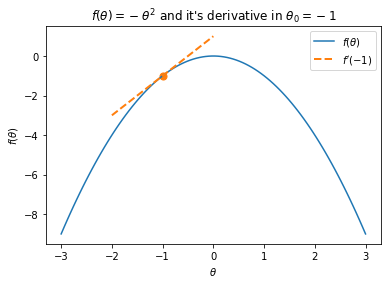

In [246]:
# define theta0
theta0 = -1

# Define a function and it's tagent
def f(theta):
  return -theta**2

def tangent(theta, theta0):
  return -2*theta0 * (theta - theta0) + f(theta0)

# Generate theta values in the range [-3, 3] 
thetaD = np.linspace(-3, 3, 100)

# Define theta data range for tangent line
trange = np.linspace(theta0-1, theta0+1, 100)

# Plot title
plt.title(r"$f(\theta)=-\theta^2$ and it's derivative in $\theta_0="+f"{theta0}$")

# Plot f, f' and theta0
plt.plot(thetaD, f(thetaD), label=r"$f(\theta)$")
plt.plot(trange, tangent(trange, theta0), 'C1--', linewidth=2, label=r"$f^\prime("+f"{theta0})$")
plt.scatter(theta0, f(theta0), color='C1', s=50)

# Add labels and legend
plt.xlabel(r"$\theta$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.show()

---

#### **PARTIAL DERIVATIVES**

Partial derivatives tell us how much a function would change when we keep all but one of its input variables constant and move a slight nudge in the direction of the one variable that is not fixed.

Suppose that $f$ is a function that depends on more than one variable, for instance: 
$$f(\theta_1, \theta_2) = \theta_1^2+\theta_2^2+\theta_1\theta_2$$
then $f$ can be reinterpreted as a family of functions of one variable indexed by the other variables: $f(\theta_1, \theta_2) = f_{\theta_1}(\theta_2)$. By fixing $\theta_1$ to a value "$a$", we get a function of a single variable $f_a(\theta_2)=a^2+\theta_2^2+a \theta_2$ and the derivative of this function is $f_a^\prime(\theta_2) = 2\theta_2+a$. The above procedure can be performed for any choice of $a$, and assembling the derivatives together into a function gives a function that describes the variation of $f$ in the $\theta_2$ direction: 
$\frac{\partial f}{\partial \theta_2}(\theta_1, \theta_2)=2\theta_2+\theta_1$; this is the partial derivative of $f$ with respect to $\theta_2$. Recalling that the gradient packs together all the partial derivative into a vector, the gradient of this function would be:
$$\nabla f(\theta) = (2\theta_1+\theta_2, 2\theta_2+\theta_1)$$

In general, the partial derivative of a function $f(\theta_1,..., \theta_n)$ in the direction $\theta_i$ at the point $(a_1, ..., a_n)$ is defined to be:
$$\frac{\partial f}{\partial \theta_i}(a_1, ..., a_n)=\lim_{h \to 0}\frac{f(a_1,...,a_i+h,...a_n)+f(a_1,...,a_i,...,a_n)}{h}$$

---

Given, for example, the function $f(\theta_1,\theta_2)=-\theta_1^2-\theta_2^2$ with $\theta_{1,2} \in [-3, 3]$, you can display the tangent plane at a point $\theta_0=(-0.5, -2)$ by running the following code:

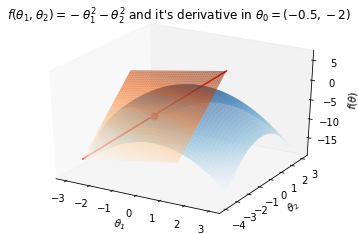

In [5]:
# define theta0
theta0 = [-0.5, -2]

# Define the function and it's tangent
def f(theta):
    return -(theta[0]**2 + theta[1]**2)

def tangent(theta, theta0):
    return f([theta0[0],theta0[1]]) - 2*(theta[0]-theta0[0])*theta0[0] - 2*(theta[1]-theta0[1])*theta0[1]

# Create a grid of theta1 and theta2 values
t1 = np.linspace(-3, 3, 100)
t2 = np.linspace(-3, 3, 100)
T1, T2 = np.meshgrid(t1, t2)

# Define theta data range for tangent plane
t1r = np.linspace(theta0[0]-2, theta0[0]+2, 100)
t2r = np.linspace(theta0[1]-2, theta0[1]+2, 100)
T1r,T2r = np.meshgrid(t1r, t2r)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"$f(\theta_1,\theta_2)=-\theta_1^2-\theta_2^2$ and it's derivative in $\theta_0=" + f"({theta0[0]}, {theta0[1]})" +"$")

# Plot f, f', theta0 and a possible tangent
ax.plot_surface(T1, T2, f([T1, T2]), cmap='Blues', alpha=0.5)
ax.plot_surface(T1r, T2r, tangent([T1r, T2r], theta0), cmap='Oranges', alpha=0.6)
ax.scatter3D(theta0[0], theta0[1], f([theta0[0], theta0[1]]), color='r', s=50)
ax.plot(t1r, t2r, tangent([t1r, t2r], theta0), color='r')

# Add labels
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$f(\theta)$')
plt.show()

At $\theta_0=(-0.5, -2)$, as the gradient of the function is $\nabla f(\theta) = [-2\theta_1, -2\theta_2]=[1,4]$, a slight nudge purely in the $\theta_1$ direction would cause a change by a factor of 1 in the output of the function while a similar change in the $\theta_2$ direction would change the output of the function by a factor of 4.

However, in general, we do not only want to know how things change when we move in either the $\theta_1$ or $\theta_2$ direction, but we also want to know **how much things would change if we move in any arbitrary direction** within the input space. 

In higher dimensions, we have a lot of options to define tangents of graphs. Take the previous plot as an example: for the black dot on the surface of $f(\theta_1, \theta_2)$, we can define as many tangents as we like; a possible choice could be the red line in the plot.

By defining some $\mathbf{v} = (v_1, v_2)$, the tangent will point in the same direction of $\mathbf{v}$, and this slope happens to be $\nabla_\mathbf{v} f(\theta)$: that's the **directional derivative**, that will be introduced next. 

---

#### **DIRECTIONAL DERIVATIVES**

If $f$ is a real-valued function on $\mathbb{R}^n$, then the partial derivatives of $f$ measure its variation in the direction of the coordinate axes. For example, if $f$ is a function of $\theta_1$ and $\theta_2$, then its partial derivatives measure the variation of $f$ in the $\theta_1$ and $\theta_2$ direction. They do not, however, directly measure the variation of $f$ in any other direction, but these are measured using **directional derivatives**.

The directional derivative of a multivariable differentiable (scalar) function along a given vector $\mathbf{v}=(v_1, ..., v_n)$ at a given point $\theta$ represents the instantaneous rate of change of the function, moving through $\theta$ with a velocity specified by $\mathbf{v}$. 
Given a vector $\mathbf{v}=(v_1, ..., v_n)$, the directional derivative of $f$ in the direction of $\mathbf{v}$ at the point $\theta$ is the limit:
$$\nabla_\mathbf{v} f(\theta)=\lim_{h \to 0}\frac{f(\theta+h\cdot\mathbf{v})-f(\theta)}{h}$$
Moreover, $\nabla_\mathbf{v} f(\theta)$ is a scalar, just like $\nabla f(\theta)$, but for each value of $\mathbf{v}$ it's a different number, indicating the slope of $f$ in the $\mathbf{v}$ direction. It's possible to prove that:
$$\nabla_\mathbf{v} f(\theta) = \nabla f(\theta)\cdot\mathbf{v}$$

---

As an example, given $f(\theta_1, \theta_2)=-\theta_1^2-\theta_2^2$, by choosing $\mathbf{v}=(4,2)$ we have that $\nabla_\mathbf{v} f(\theta)=(-2\theta_1, -2\theta_2)\cdot(4,2)^\top=-8\theta_1-4\theta_2$ and, by evaluationg the directional derivative in $\theta=(-0.5, -2)$ we have that $\nabla_\mathbf{v} f(\theta)=4+4=8$. This means that, given that we are at the point (-0.5, -2) in our input plane, taking a tiny step in the direction of the vector (4, 2) would change the output of our function by a factor of 8.

---

#### **DIRECTION OF STEEPEST ASCENT**

When training Neural Networks, the problem we seek to solve is that we want to know the direction that would result in the greatest increase in our loss, given that we are at a point $\theta$. Once we know this direction we take a step in the opposite direction which would lead to the greatest reduction in the loss. 

The directional derivative can actually help us measure how good (or bad) a particular direction is. A possible way to solve this problem could be to find all the directional derivatives (considering all possible directions in wich we could move) and then choose the best direction as the one with the largest directional derivative. However, testing all possible direction would be costly.

Our goal is to find: 
$$\max_{\lvert\mathbf{v}\rvert=1} \nabla f(\theta)\cdot\mathbf{v}$$
By fixing the magnitude (lenght) of the vector to $\lvert\mathbf{v}\rvert=1$, we ensure not to pick vector based on a lager magnitude, but on the direction only.

Recalling that the dot product between two vectors $\vec{u}$ and $\vec{v}$ is:
$$\vec{u}\cdot\vec{v}=\lvert\vec{u}\rvert\cdot\lvert\vec{v}\rvert\cdot\cos\theta$$
where $\theta$ is the angle between $\vec{u}$ and $\vec{v}$, it's evident that two vector pointing in the same direction will have a larger dot product (higher *similarity*). 

As the directional derivative is the dot product $\nabla_\mathbf{v} f(\theta) = \nabla f(\theta)\cdot\mathbf{v}$, the vector $\mathbf{v}$ that would maximize the directional derivative (and result in the greatest increase in our function) is the vector that points in the same direction as the gradient (which is the gradient itself). This is why the gradient is the direction of steepest ascent, and gradient descent takes a step in the opposite direction.

---

As an example, you can observe the iterations of the Gradient Descent (**GD**) algorithm on the function $f(\theta_1, \theta_2)=\theta_1^2+\theta_2^2$ by running the code below: starting from $\theta_0=(-15,15)$ we will see, iteratively, how the points are directed to the local minima of $f$:

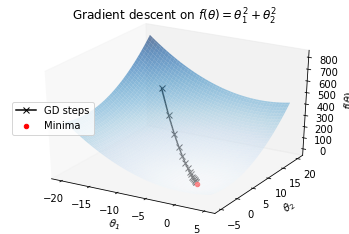

In [325]:
# Define the initial values of theta
theta0 = np.array([-15, 15])

# Define the function
def f(theta):
    return theta[0]**2 + theta[1]**2

# Define the gradient of the cost function
def gradient(theta):
    return np.array([2*theta[0], 2*theta[1]])

# Define the parameters for the plot
t1 = np.linspace(-20, 5, 100)
t2 = np.linspace(-5, 20, 100)
T1, T2 = np.meshgrid(t1, t2)

# Set the learning rate
alpha = 0.1

# Initialize list of gradients
grads = list()

# Perform gradient descent and save points in theta_list
theta_list = [theta0.copy()]
for i in range(15):
    grad = gradient(theta0)
    grads.append(grad)
    theta0 = theta0 - alpha * grad
    theta_list.append(theta0.copy())
theta_list = np.array(theta_list)
grads = np.array(grads)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"Gradient descent on $f(\theta)=\theta_1^2+\theta_2^2$")

# Plot f, GD steps and minima
ax.plot_surface(T1, T2, f([T1, T2]), cmap='Blues', alpha=0.6)
ax.plot(theta_list[:, 0], theta_list[:, 1], f([*theta_list.T]), '-x', color='black', label="GD steps", alpha=1)
ax.scatter(0, 0, 0, color='r', label='Minima')

# Add labels and legend
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$f(\theta)$')
plt.legend(loc='center left')
plt.show()

##**Backpropagation**

In neural networks, the usual way of computing the gradient $\nabla f(\theta)$ is by using a technique called **backpropagation**, which is essentially the chain rule from calculus.

The backpropagation algorithm consists of two main steps:
1. **Forward pass**: compute the outpute of the network $f(\theta)$ for a given input $\theta$.
2. **Backward pass**: given $f(\theta)$, compute the loss (error) and propagates it backwards through the model's layers, computing the gradient of the loss with respect to the parameters of each layer.

This means that, in order to compute the gradients w.r.t. the parameters of the network, we have to go through the network twice. The authors of the paper "Gradients without Backpropagation" [3] propose a simple way of computing the gradient in a single forward pass.

#### **FORWARD GRADIENT**
Given a function $f:\mathbb{R}^n\to\mathbb{R}$, the forward gradient $\mathbf{g}:\mathbb{R}^n\to\mathbb{R}^n$ is defined as:
$$\mathbf{g}_\mathbf{v}(\theta):= \nabla_\mathbf{v} f(\theta)\cdot\mathbf{v}=(\nabla f(\theta)\cdot\mathbf{v})\mathbf{v}$$
where $\theta\in\mathbb{R}^n$ is the point at which we are evaluating
the gradient, $\mathbf{v}\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $\mathbf{v}\backsim p(\mathbf{v})$ such that $\mathbf{v}$’s scalar components $v_i$ are independent and have zero mean and unit variance for all $i$, and $\nabla f(\theta)\cdot\mathbf{v}\in\mathbb{R}$ is the directional
derivative of $f$ at point $\theta$ in direction $\mathbf{v}$.

Moreover, the *forward gradient* $\mathbf{g}_\mathbf{v}(\theta)$ is an unbiased estimator of the gradient $\nabla f(\theta)$.


Using a simple function, we can define the forward gradient as follow:

In [294]:
def fwd_grad(obj_f, v, theta0):    
    # Define h (should be a small number)
    h = 1e-10

    # Compute ∇ᵥf(θ)
    grad_v_f = ((obj_f(theta0 + h*v) - obj_f(theta0)) / h)

    # Scale v with grad_f to compute g
    g = grad_v_f.reshape(-1, 1) * v

    return g

---

Let's now take as an example the function $f(\theta_1, \theta_2)=\theta_1^2+\theta_2^2$ for wich we want to compute the gradients at a given point $\theta_0=(-15,15)$. By computing the gradients manually we have that $\nabla f(\theta_1,\theta_2)=(2\theta_1, 2\theta_2)$ so $\nabla f(-15,15)=(-30,30)$; this can easily be verified by computing directional derivatives using the canonical basis, i.e. $\mathbf{v}=\begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}$:

In [265]:
# Define theta0
theta0 = np.array([[-15, 15]])

# Define the function 
def f(theta):
    return theta[:,0]**2 + theta[:,1]**2

# Define h (very small) and vector v (as canonical base vectors)
h = 1e-10
v = np.array([[1, 0], [0, 1]])

# Print result
print(f'Approximate derivative: {fwd_grad(f, v, theta0).sum(axis=0)}') 

Approximate derivative: [-29.99968274  29.99968274]


As we can see, the result is very close to the real value. 

Let's now compute several random vectors $\mathbf{v}$ and the forward gradients $\mathbf{g}_\mathbf{v}(\theta)$.

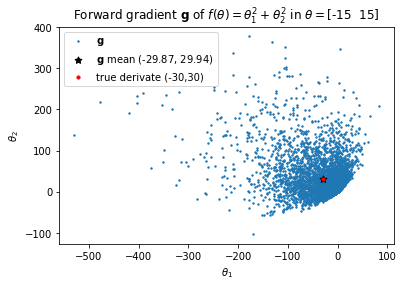

In [266]:
# Set a seed to keep it reproducible
np.random.seed(0) 

# Geneate a million random vectors of size 2
v = np.random.randn(1_000_000, 2)

# Compute forward gradient g
g = fwd_grad(f, v, theta0)

# Plot g, it's mean and true derivative
plt.scatter(g[:5000,0], g[:5000,1], s=2, label=r'$\mathbf{g}$')
plt.scatter(g.mean(axis=0)[0], g.mean(axis=0)[1], c='k', s=50, marker=(5, 1), label=r"$\mathbf{g}$ mean "+f'({g.mean(axis=0)[0]:.2f}, {g.mean(axis=0)[1]:.2f})')
plt.scatter(2*theta0[0][0], 2*theta0[0][1], c='r', s=10, label="true derivate "+f'({2*theta0[0][0]},{2*theta0[0][1]})')

# Add labels and legend
plt.title(r'Forward gradient $\mathbf{g}$ of $f(\theta)=\theta_1^2+\theta_2^2$ in $\theta=$'+f'{theta0.sum(axis=0)}')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.legend(loc='upper left')
plt.show()

This time, although not the canonical basis $\mathbf{v}=\begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}$ but random vectors were used, the result is the same. That's because, as $\mathbf{g}_\mathbf{v}(\theta)$ is an unbiased estimator of the gradient $\nabla f(\theta)$, by sampling many $\mathbf{v}$'s and computing (and average) the corresponding forward gradients, we end up with a pretty good approximation of the true gradient. 

---

Let us now try to perform a gradient descent using the forward gradient:

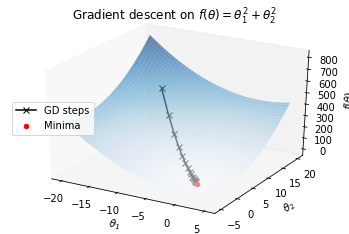

In [324]:
# Define the initial values of theta
theta0 = np.array([-15, 15])

# Define the function
def f(theta):
    return theta[0]**2 + theta[1]**2

def f_grad(theta):
    return theta[:,0]**2 + theta[:,1]**2

# Define the parameters for the plot
t1 = np.linspace(-20, 5, 100)
t2 = np.linspace(-5, 20, 100)
T1, T2 = np.meshgrid(t1, t2)

# Set the learning rate
alpha = 0.1

# Initialize list of gradients
fwd_grads = list()

# Perform gradient descent and save points in theta_list
theta_list = [theta0.copy()]
for i in range(15):
    grad = fwd_grad(f_grad, np.random.randn(1_000_000, 2), np.array([theta0])).mean(axis=0)
    fwd_grads.append(grad)
    theta0 = theta0 - alpha * grad  
    theta_list.append(theta0.copy())
theta_list = np.array(theta_list)
fwd_grads = np.array(fwd_grads)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"Gradient descent on $f(\theta)=\theta_1^2+\theta_2^2$")

# Plot f, GD steps and minima
ax.plot_surface(T1, T2, f([T1, T2]), cmap='Blues', alpha=0.6)
ax.plot(theta_list[:, 0], theta_list[:, 1], f([*theta_list.T]), '-x', color='black', label="GD steps", alpha=1)
ax.scatter(0, 0, 0, color='r', label='Minima')

# Add labels and legend
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$f(\theta)$')
plt.legend(loc='center left')
plt.show()

As we can see we get pretty good results, compared to the one obtained using the mathematical formulation to compute the gradient.

Let us now actually analyze how far the forward gradient approximation deviates from the true value:

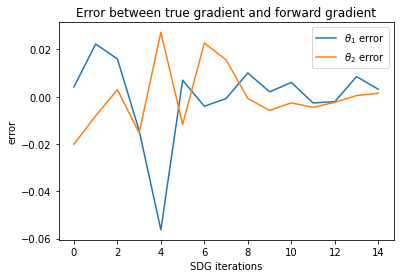

In [336]:
plt.plot(grads[:,0]-fwd_grads[:,0], label=r'$\theta_1$ error')
plt.plot(grads[:,1]-fwd_grads[:,1], label=r'$\theta_2$ error')

plt.title(r"Error between true gradient and forward gradient")
plt.xlabel(r'SDG iterations')
plt.ylabel('error')
plt.legend()
plt.show()

### References

[1] [Derivative](https://en.wikipedia.org/wiki/Derivative).

[2] Kofi Asiedu Brempong, 2020 [I Finally Understood Backpropagation: And you can too...](https://towardsdatascience.com/i-finally-understood-backpropagation-and-you-can-too-44f7dd98ff52)

[3] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. [Gradients without Backpropagation](https://arxiv.org/abs/2005.00817).

[4] Robert Tjarko Lange, 2019. [Forward Mode Automatic Differentiation & Dual Numbers](https://roberttlange.github.io/posts/2019/08/blog-post-6/)